# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

Coefficients: 
 [  1.73010708e+00   3.76715965e-01   9.44969469e-01   2.23771633e+00
   1.84048838e+00  -9.45890271e-01   9.09843690e-01  -1.35191389e-01
  -8.87978488e-02   4.02946694e-01   1.58887653e-01   1.42988657e+00
   7.19391760e-01   1.11818592e-01   4.20823066e-01   3.20790457e-01
   1.47518202e+00  -2.03204402e-01   2.72613014e-01  -8.28248854e-01
  -2.55585799e+00   6.38347359e-01   8.64929781e-01  -6.97358425e-01
   2.21102864e+00  -1.41199306e+00   4.03031601e-04  -1.53240988e-01
   1.52809085e+00   1.38848453e+00   1.54428539e-01   3.50411184e-01
  -8.41699643e-01  -1.99067763e+00  -2.82816462e-01   1.38975298e-01
   1.18812688e+00   1.18006876e+00  -3.63686523e-01  -2.81024222e-01
  -1.00488303e+00  -1.39344463e+00  -1.66753203e+00   1.97555305e+00
  -4.86520132e-01  -3.91853377e-01  -1.20953729e+00   7.44022096e-01
  -1.61640329e+00  -1.85639486e-01  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -1.08109414e-02   0.00000000e+00   0.00000000e+00
   0.00000000e+00 

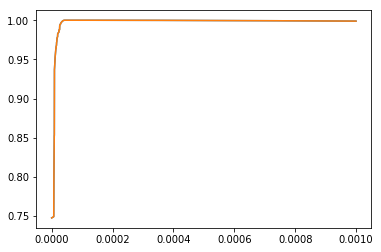

In [25]:
import matplotlib.pyplot as plt
import numpy as np
#matplotlib inline
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
df1=pd.read_csv("/Users/tuleg/Documents/APMAE4990-/data/hw2data.csv")

#setting y to be the y variable in the dataframe
y=df1['y']

#setting X to be all other features
X=df1.drop(['y'], axis=1)
#size of X and y
size=224

#splitting features
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

#note y and x have same size (both from df1)
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

#
#plt.subplot(2, 1, 1)

# Fill these in
alphas = np.logspace(-8,-3,1000)
from sklearn.linear_model import Lasso
scores = []

for alpha in alphas:
        regr = Lasso(alpha=alpha, max_iter=1500,
   normalize=True)
        
        #train the model with training data
        regr.fit(X_train, y_train)
        scores.append(regr.score(X_test,y_test))
        
plt.plot(alphas,scores)

#train_errors=[]
#test_errors=[]


alpha_optim=0



#plt.semilogx(alphas, train_errors, label='Train')
#plt.semilogx(alphas, test_errors, label='Test')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
#plt.legend(loc='lower left')
#plt.ylim([0, 1.2])
#plt.xlabel('Regularization parameter')
#plt.ylabel('Performance')
Ypred = regr.predict(X_test)
print('Coefficients: \n', regr.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, Ypred))
#R^2 score
print('R^2 score: %.2f' % r2_score(y_test, Ypred))

plt.show()


e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

f) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [ ]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_best)

In [473]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

In [479]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))